# Use this notebook to make plots with wrfout files for various ensembles
Ensemble: wrfout_10_2 - Morrison-MYJ schemes
## Notebook compiled by Jeremiah Otero
## Adapted from Steve Nesbitt's wrf_plot_FULL_domain.py
Link: https://github.com/swnesbitt/wrfplotting/blob/master/wrf_plot_FULL_domain.py

In [1]:
## Bring in the important stuff!

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os
import xarray as xr

from netCDF4 import Dataset
from matplotlib.cm import get_cmap
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from pandas import Timestamp
from wrf import to_np, getvar, smooth2d, get_basemap, latlon_coords, extract_times, ALL_TIMES, interplevel
from glob import glob

mpl.use('Agg')
%matplotlib inline

/glade/u/apps/ch/opt/pythonpkgs/2.7/xarray/0.9.5/intel/16.0.3/lib/python2.7/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime
/glade/u/apps/ch/opt/pythonpkgs/2.7/matplotlib/2.0.2/gnu/6.3.0/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
## Make fonts look nice

mpl.font_manager._rebuild()

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.style'] = 'normal'

In [3]:
## Define some important landmarks

def landmarks():
    landmark_dict = {'C':(-64.2123,-31.3154),
                    'M':(-68.7987,-32.8278),
                    #'3':(-64.1131,-32.1767),
                    #'4':(-64.34992,-33.13067), 
                    #'Y':(-64.7545,-32.1062),
                    #'S':(-63.978435,-31.715689),
                    'SR':(-68.285522,-34.587997),
                    'SL':(-66.33694,-33.30278)}
    return landmark_dict

landmark_dict=landmarks()

In [4]:
## Select zoom
## available options are: 'fullest' , 'full' , 'cordoba_zoom' , 'mendoza_zoom'

zoom='fullest'

titlestr='GFS-WRF' # create title for figure purposes
modname='GFS' # identify model for figure purposes

## Select ensemble run
## available options are: 'wrfout_8_2' , 'wrfout_10_2'

## named based on ensemble physical parameterizations - edits to namelist.input
    ## mp_physics: 8 = Thompson; 10 = Morrison; 17 = NSSL
    ## bl_pbl_physics: 1 = YSU; 2 = MYJ

ensemble='wrfout_10_2' # change this right here

if ensemble is 'wrfout_8_2':
    titl_ensemble='Thompson-MYJ'
if ensemble is 'wrfout_10_2':
    titl_ensemble='Morrison-MYJ'
if ensemble is 'wrfout_17_2':
    titl_ensemble='NSSL-MYJ'
if ensemble is 'wrfout_8_1':
    titl_ensemble='Thompson-YSU'
if ensemble is 'wrfout_10_1':
    titl_ensemble='Morrison-YSU'
if ensemble is 'wrfout_17_1':
    titl_ensemble='NSSL-YSU'

In [5]:
## Bring in wrfout data as 'filenames'

path = '/glade/work/jpiers/WRFV3/run/'+ensemble # set path to where wrfout files are located
filenames = sorted(glob(path+'/wrfout_d0*')) # define filenames, sorted by time

In [6]:
## Create lists 'files' and 'times' that will be used for making plots
## Print times - for diagnostic purposes

files=[]
times=[]

for file in filenames:
    files.append(Dataset(file))
    print(os.path.basename(file)[11:])
    times.append(pd.to_datetime(os.path.basename(file)[11:],format='%Y-%m-%d_%H:%M:%S'))

2016-12-25_00:00:00
2016-12-25_01:00:00
2016-12-25_02:00:00
2016-12-25_03:00:00
2016-12-25_04:00:00
2016-12-25_05:00:00
2016-12-25_06:00:00
2016-12-25_07:00:00
2016-12-25_08:00:00
2016-12-25_09:00:00
2016-12-25_10:00:00
2016-12-25_11:00:00
2016-12-25_12:00:00
2016-12-25_13:00:00
2016-12-25_14:00:00
2016-12-25_15:00:00
2016-12-25_16:00:00
2016-12-25_17:00:00
2016-12-25_18:00:00
2016-12-25_19:00:00
2016-12-25_20:00:00
2016-12-25_21:00:00
2016-12-25_22:00:00
2016-12-25_23:00:00
2016-12-26_00:00:00
2016-12-26_01:00:00
2016-12-26_02:00:00
2016-12-26_03:00:00
2016-12-26_04:00:00
2016-12-26_05:00:00
2016-12-26_06:00:00
2016-12-26_07:00:00
2016-12-26_08:00:00
2016-12-26_09:00:00
2016-12-26_10:00:00
2016-12-26_11:00:00
2016-12-26_12:00:00
2016-12-26_13:00:00
2016-12-26_14:00:00
2016-12-26_15:00:00
2016-12-26_16:00:00
2016-12-26_17:00:00
2016-12-26_18:00:00
2016-12-26_19:00:00
2016-12-26_20:00:00
2016-12-26_21:00:00
2016-12-26_22:00:00
2016-12-26_23:00:00
2016-12-27_00:00:00
2016-12-27_01:00:00


In [7]:
## Define function 'make_plot'

def make_plot(cffield,lfield,lfield2,ufld,vfld,params):
# Get the latitude and longitude points

    print(params['time_index'])
    
    lats, lons = latlon_coords(cffield)

    # Determine view/zoom level

    if params['zoom'] == 'fullest':
        bm = Basemap(projection='lcc',width=5400*550,height=6400*375,
        resolution='i',lat_1=-32.0,lat_2=-32.0,lat_0=-32.0,lon_0=-65.25)
        fs=12
        params['skip']=30
    
    if params['zoom'] == 'full':
        bm = Basemap(projection='lcc',width=3000*550,height=3000*375,
        resolution='i',lat_1=-32.8,lat_2=-32.8,lat_0=-32.8,lon_0=-67.0)
        fs=12
        params['skip']=17

    if params['zoom'] == 'cordoba_zoom':
        bm = Basemap(projection='lcc',width=1500*550,height=1500*375,
        resolution='i',lat_1=-32.2,lat_2=-32.2,lat_0=-32.2,lon_0=-65.0)
        fs=14 
        params['skip']=9
    
    if params['zoom'] == 'mendoza_zoom':
        bm = Basemap(projection='lcc',width=1500*550,height=1500*375,
        resolution='i',lat_1=-33.2,lat_2=-33.2,lat_0=-33.2,lon_0=-69.0)
        fs=14 
        params['skip']=9

    # Create a figure
    fig = plt.figure(figsize=(12,9))

    # Add geographic outlines
    bm.drawcoastlines(linewidth=0.75)
    #bm.drawstates(linewidth=1.)
    bm.drawcountries(linewidth=1.)

    # Convert the lats and lons to x and y.  Make sure you convert the lats and lons to
    # numpy arrays via to_np, or basemap crashes with an undefined RuntimeError.
    x, y = bm(to_np(lons), to_np(lats))

    # Draw surface pressure in hPa; draw wind speed contours for MLCAPE
    if lfield is not None:
        CS=bm.contour(x, y, to_np(lfield), 10, colors="black", levels=params['llevels'],linewidths=1.0)
        plt.clabel(CS, inline=1, fontsize=12, fmt='%d')

    # Draw terrain contour for 1000 m above sea level
    if lfield2 is not None:
        CS=bm.contour(x, y, to_np(lfield2), 10, colors="dimgrey", levels=params['llevels2'],linewidths=2.25)
        #plt.clabel(CS, inline=1, fontsize=12, fmt='%d')
    
    # Draw surface wind barbs
    if ufld is not None:
        bm.barbs(x[::params['skip'],::params['skip']], 
                 y[::params['skip'],::params['skip']], 
                 to_np(ufld[::params['skip'],::params['skip']]),
                 to_np(vfld[::params['skip'],::params['skip']]), length=5, linewidth=0.75, zorder=10)

    if not('lalpha' in params):
        params['lalpha']=None
        

    # Draw the contours and filled contours
    bm.contourf(x, y, to_np(cffield), 10, cmap=get_cmap(params['ccmap']), levels=params['clevels'], extend='both',
               alpha=params['lalpha'])

    
    if zoom is 'fullest':
        parallels = np.arange(-50.,-10.,5.)
        meridians = np.arange(-90.,-45.,5.)
    else:    
        parallels = np.arange(-50.,-10.,2.)
        meridians = np.arange(-90.,-46.,2.)
    
    # labels = [left,right,top,bottom]
    bm.drawparallels(parallels,labels=[False,True,False,False],linewidth=0.5,dashes=[2,2])
    bm.drawmeridians(meridians,labels=[False,False,False,True],linewidth=0.5,dashes=[2,2])

    # Add a color bar
    plt.colorbar(shrink=.62, extend='both')

    timediff=params['times'][params['time_index']]-params['times'][0]
    timediff_secs=int(timediff.total_seconds()//3600)

    plt.title(titlestr+': '+titl_ensemble+' '+cffield.description+' ('+cffield.units+')\n'+
             "Initialized: "+params['times'][0].strftime('%Y-%m-%d %H:%M')+"Z Forecast hour: "+'{:03d}'.format(timediff_secs)+" Valid: "+params['times'][params['time_index']].strftime('%Y-%m-%d %H:%M')+'Z')

    for key in landmark_dict.keys():
        kx,ky=bm(landmark_dict[key][0],landmark_dict[key][1])
        plt.text(kx,ky,key,fontsize=fs,
                        ha='center',va='center',color='b')
    #fig.figimage(im, fig.bbox.xmax-290, fig.bbox.ymin,zorder=10)


## Make and save plots!
See Nesbitt's code, as named above, to bring in the params for different variables. Some modifications necessary, as outlined below.

0


/glade/u/apps/ch/opt/pythonpkgs/2.7/matplotlib/2.0.2/gnu/6.3.0/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/glade/u/apps/ch/opt/pythonpkgs/2.7/matplotlib/2.0.2/gnu/6.3.0/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3572: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/glade/u/apps/ch/opt/pythonpkgs/2.7/matplotlib/2.0.2/gnu/6.3.0/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/glade/u/apps/ch/opt/pythonpkgs/2.7/matplotlib/2.0.2/gnu/6.3.0/lib/python2.7/site-packages/matplotlib/contour.py:1514: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/glade/u/apps/ch/opt/pythonpkgs/2.7/ma

1
2


/glade/u/apps/ch/opt/pythonpkgs/2.7/matplotlib/2.0.2/gnu/6.3.0/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


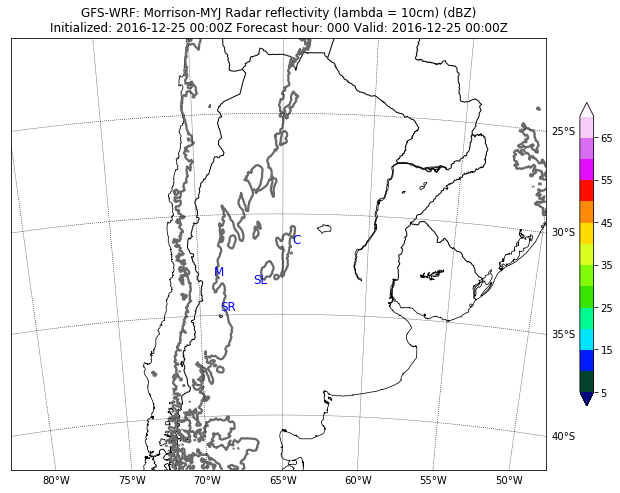

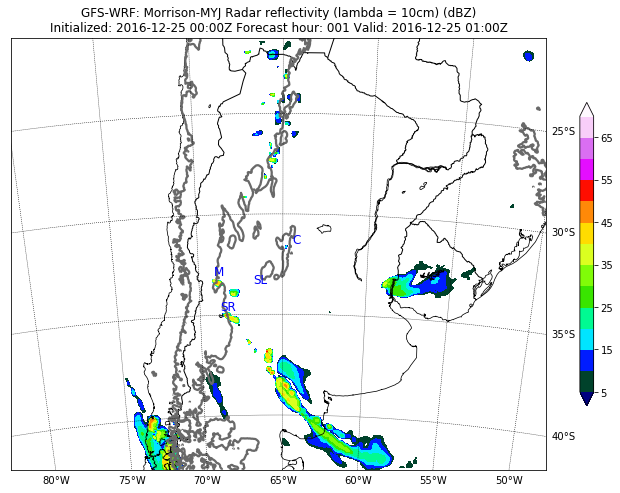

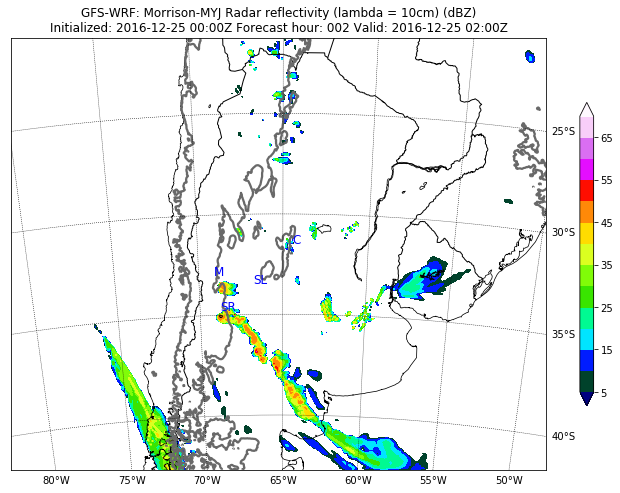

In [8]:
#=========================Radar Reflectivity (lambda=10cm)=========================

## Important: the following through tindex=i must be added to Nesbitt's code for each variable, such as pw.
## Indentation matters! take the bottom top dimension- 4d variable

outpath = 'DEC16_images/'+ensemble+'/refl' # change directory names to fit variable AND ENSEMBLE!
for i,f in enumerate(files):
    if i > 2:                           # change 'i>2' depending on how many indices aka times you want iterated
        break
    tindex=i
    
    params={'outpath':outpath,
            'modname':modname,
            'modfld':'Radar Reflectivity (lambda = 10cm)',
            'cfield':'REFL_10CM',
            'clevels':np.arange(5,75,5.),
            'ccmap':"gist_ncar",
            'llevels':np.arange(510,606,6),
            'llevels2':[1000],
            'time_index':tindex,
            'times':times,
            'zoom':zoom,
            'skip':17}

    dbz = getvar(files, 'dbz', timeidx=params['time_index'])
    ter = getvar(files, 'ter', timeidx=params['time_index'], units="m")
    z = getvar(files, 'z', timeidx=params['time_index'], units="m")

    ter_3d=np.tile(ter.values,[41,1,1])
    z.values=z.values-ter.values
    #cffield = interplevel(dbz, z, 1000)
    cffield = xr.DataArray(np.max(dbz.values, axis=0), coords=dbz.coords, dims=dbz.dims[1:],attrs=dbz.attrs)
    cffield.values=np.ma.masked_less(cffield.values,5.)
    cffield.attrs['description']='Radar reflectivity (lambda = 10cm)'
    lfield = None
    lfield2 = getvar(files, 'ter', timeidx=params['time_index'], units='m')
    ufld=None
    vfld=None

    make_plot(cffield,lfield,lfield2,ufld,vfld,params)

## Important: add the following to create proper directory and save .png in it
    
    ## Make directory for variable as defined above
    os.system('mkdir -p '+outpath)

    # save figure in outpath. named based on variable and time. must change '/pw_' for other variables
   # plt.savefig(outpath+'/'+zoom+'_refl_'+times[i].strftime('%Y-%m-%d_%H:%M:%S')+'.png', bbox_inches="tight", dpi=200)

0
1
2


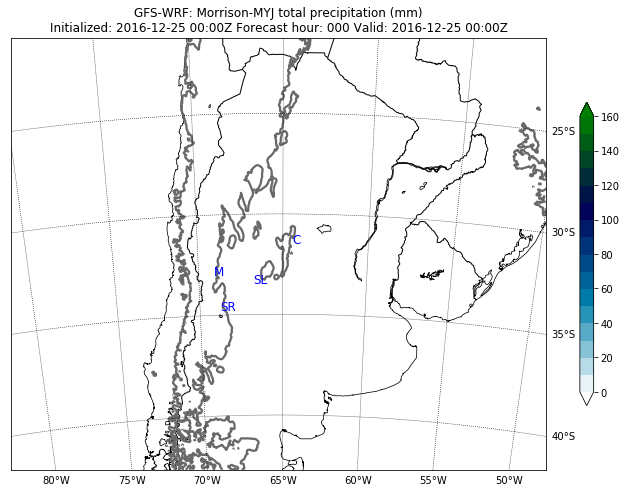

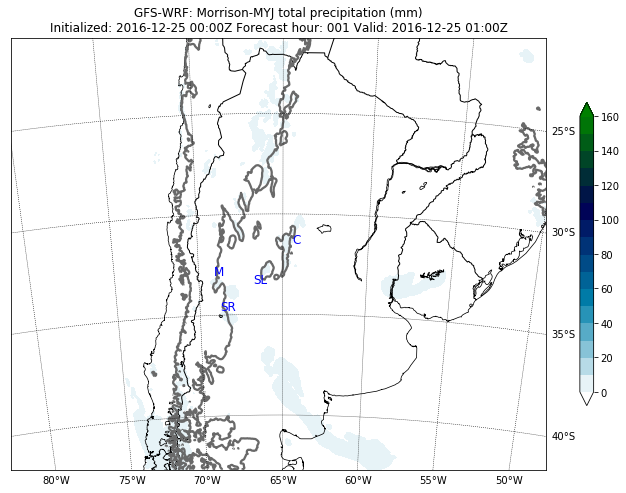

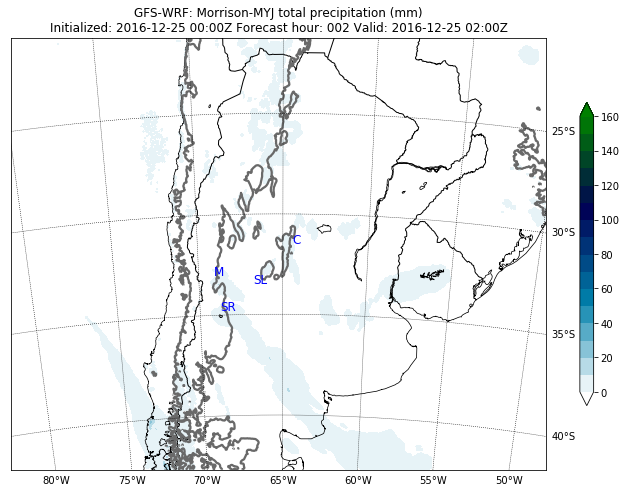

In [12]:
#====================TOTAL PRECIPITAITON=========================

## Important: the following through tindex=i must be added to Nesbitt's code for each variable, such as pw.
## Indentation matters!

outpath = 'DEC16_images/'+ensemble+'/rainnc' # change directory names to fit variable AND ENSEMBLE!
for i,f in enumerate(files):
    if i>2:                           # change 'i>2' depending on how many indices aka times you want iterated
        break
    tindex=i
    
    params={'outpath':outpath,
            'modname':modname,
            'modfld':'Total_Precipitation',
            'cfield':'RAINNC',
            'clevels':np.arange(0,165,10),
            'ccmap':"ocean_r",
            'llevels':None,
            'llevels2':[1000],
            'time_index':tindex,
            'times':times,
            'zoom':zoom,
            'skip':17}

    cffield=None
    cffield = getvar(files, params['cfield'], timeidx=params['time_index'])
    cffield.attrs['description']='total precipitation'
    cffield.attrs['units']='mm'
    lfield = None
    lfield2 = getvar(files, 'ter', timeidx=params['time_index'], units='m')
    ufld = None
    vfld = None

    make_plot(cffield,lfield,lfield2,ufld,vfld,params)

## Important: add the following to create proper directory and save .png in it
    
    ## Make directory for variable as defined above
    os.system('mkdir -p '+outpath)

    # save figure in outpath. named based on variable and time. must change '/pw_' for other variables
   # plt.savefig(outpath+'/'+zoom+'_rainnc_'+times[i].strftime('%Y-%m-%d_%H:%M:%S')+'.png', bbox_inches="tight", dpi=200)

0
1
2


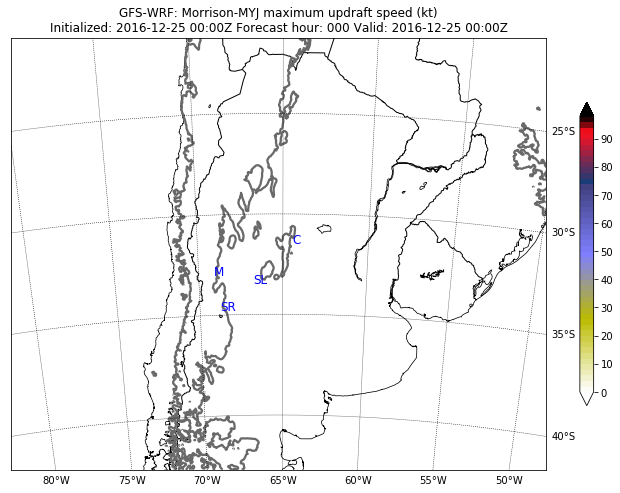

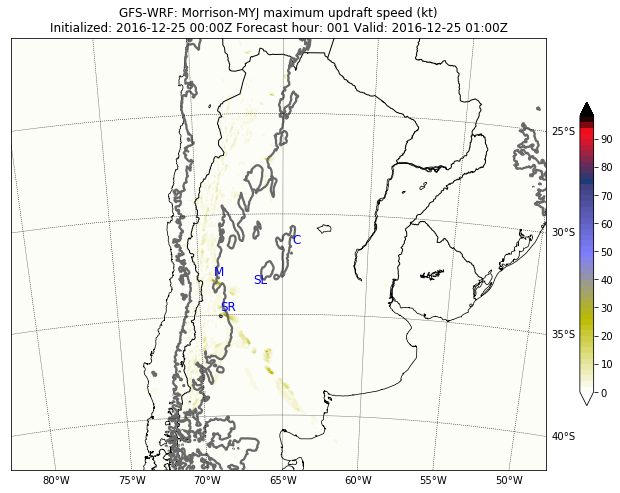

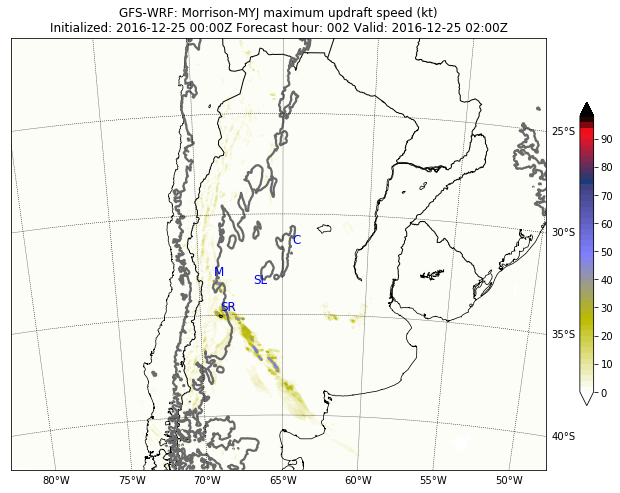

In [11]:
#====================MAX UPDRAFT=========================

## Important: the following through tindex=i must be added to Nesbitt's code for each variable, such as pw.
## Indentation matters! take the bottom top dimension- 4d variable

outpath = 'DEC16_images/'+ensemble+'/w_up_max' # change directory names to fit variable AND ENSEMBLE!
for i,f in enumerate(files):
    if i>2:                           # change 'i>2' depending on how many indices aka times you want iterated
        break
    tindex=i


    params={'outpath':outpath,
            'modname':modname,
            'modfld':'Maximum_Updraft_Speed',
            'cfield':'W_UP_MAX',
            'clevels':np.arange(0,100,2),
            'ccmap':"gist_stern_r",
            'llevels':None,
            'llevels2':[1000],
            'time_index':tindex,
            'times':times,
            'zoom':zoom,
            'skip':17}

    try:
        cffield = getvar(files, params['cfield'], timeidx=params['time_index'], units='kt')
        cffield.values=cffield.values*1.94384
        cffield.attrs['description']='maximum updraft speed'
        cffield.attrs['units']='kt'
        lfield = None
        lfield2 = getvar(files, 'ter', timeidx=params['time_index'], units='m')
        ufld = None
        vfld = None

        make_plot(cffield,lfield,lfield2,ufld,vfld,params)
    except: print(params['cfield']," is not in the file, skipping")
        
## Important: add the following to create proper directory and save .png in it
    
    ## Make directory for variable as defined above
    os.system('mkdir -p '+outpath)

    # save figure in outpath. named based on variable and time. must change '/pw_' for other variables
   # plt.savefig(outpath+'/'+zoom+'_w_up_max_'+times[i].strftime('%Y-%m-%d_%H:%M:%S')+'.png', bbox_inches="tight", dpi=200)

0
1
2


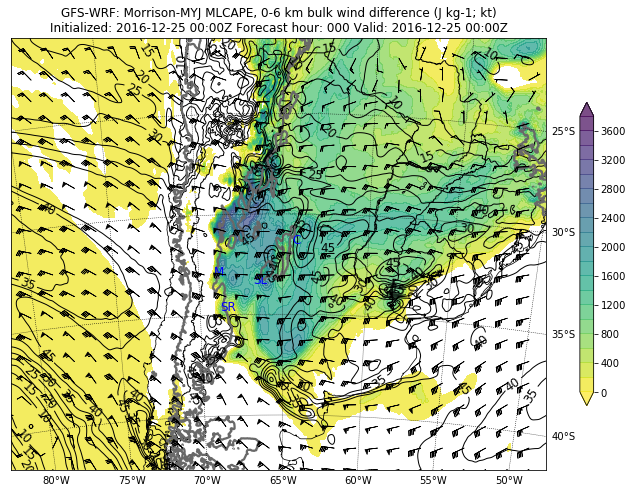

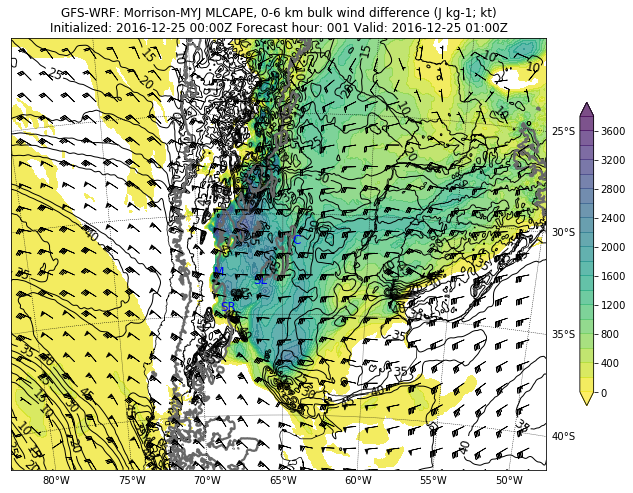

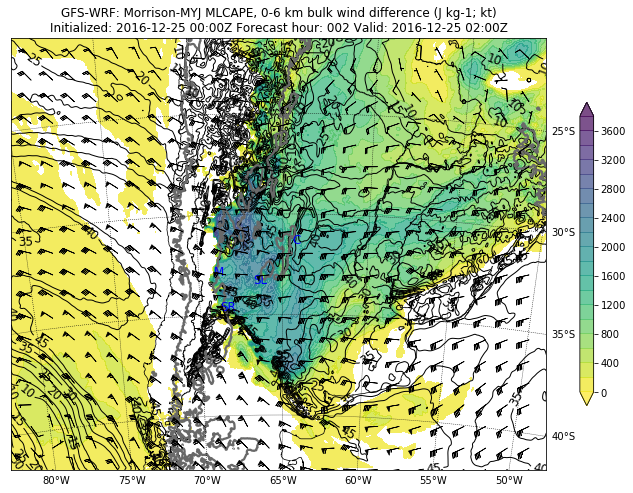

In [11]:
#=====================MLCAPE; 0-6 KM WIND=========================

## Important: the following through tindex=i must be added to Nesbitt's code for each variable, such as pw.
## Indentation matters! take the bottom top dimension- 4d variable

outpath = 'DEC16_images/'+ensemble+'/mlcape_0-6kmwind' # change directory names to fit variable AND ENSEMBLE!
for i,f in enumerate(files):
    if i>2:                           # change 'i>2' depending on how many indices aka times you want iterated
        break
    tindex=i

    params={'outpath':outpath,
            'modname':modname,
            'modfld':'Mixed-layer_CAPE',
            'cfield':'mlcape_0-6kmwind',
            'clevels':np.arange(0,4000,200),
            'ccmap':"viridis_r",
            'llevels':np.arange(10,50,5),
            'llevels2':[1000],
            'lalpha':0.7,
            'time_index':tindex,
            'times':times,
            'zoom':zoom,
            'skip':17}


    uvmet10 = getvar(files, 'wspd_wdir10', timeidx=params['time_index'], units="kt")

    ter = getvar(files, 'ter', timeidx=params['time_index'], units="m")
    z = getvar(files, 'z', timeidx=params['time_index'], units="m")
    p = getvar(files, 'p', timeidx=params['time_index'], units="hPa")
    u = getvar(files, 'ua', timeidx=params['time_index'], units="kt")
    v = getvar(files, 'va', timeidx=params['time_index'], units="kt")

    ter_3d=np.tile(ter.values,[41,1,1])
    z.values=z.values-ter.values
    u2 = interplevel(u, z, 6000)
    v2 = interplevel(v, z, 6000)
    uvmet = getvar(files, 'uvmet10', timeidx=params['time_index'], units='kt')
    ufld = uvmet.isel(u_v=0)
    vfld = uvmet.isel(u_v=1)

    u2.values=u2.values-ufld.values
    v2.values=v2.values-vfld.values

    lfield = uvmet10.isel(wspd_wdir=0)
    lfield.values=smooth2d(np.sqrt(u2.values**2.+v2.values**2.),3) # contours wind speeds
   # lfield = None

    lfield2 = getvar(files, 'ter', timeidx=params['time_index'], units='m')

    sounding_parameters=getvar(files, 'cape_2d', timeidx=params['time_index'])
    cffield = sounding_parameters.isel(mcape_mcin_lcl_lfc=0)

    cffield.attrs['description']='MLCAPE, 0-6 km bulk wind difference'
    cffield.attrs['units']='J kg-1; kt'
    uvmet = getvar(files, 'uvmet10', timeidx=params['time_index'], units='kt')
    ufld = u2
    vfld = v2

    # plot MLCAPE, surface pressure, terrain, wind barbs
    make_plot(cffield,lfield,lfield2,ufld,vfld,params)
    
## Important: add the following to create proper directory and save .png in it
    
    ## Make directory for variable as defined above
    # os.system('mkdir -p '+outpath)

    # save figure in outpath. named based on variable and time. must change '/pw_' for other variables
   # plt.savefig(outpath+'/'+zoom+'_mlcape_0-6kmwind_'+times[i].strftime('%Y-%m-%d_%H:%M:%S')+'.png', bbox_inches="tight", dpi=200)

0
1
2


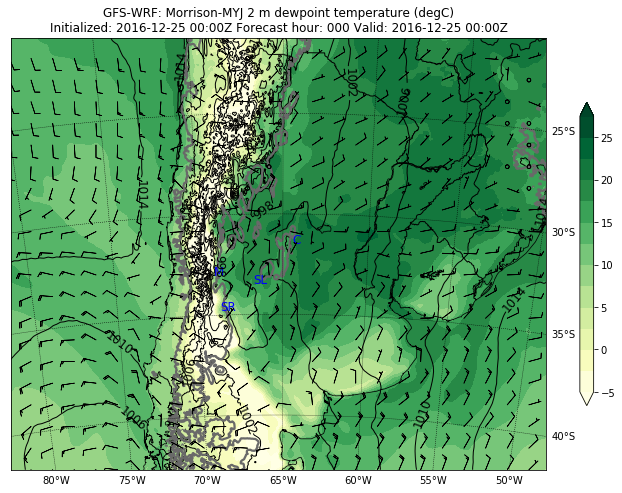

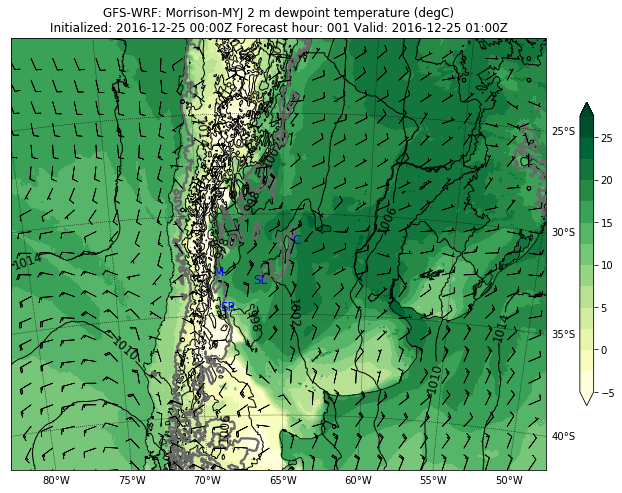

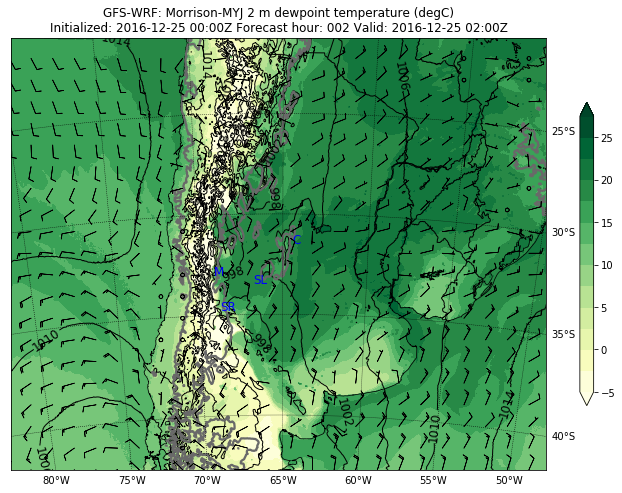

In [14]:
#=====================2 M DWPT=========================
    
## Important: the following through tindex=i must be added to Nesbitt's code for each variable, such as pw.
## Indentation matters! take the bottom top dimension- 4d variable

outpath = 'DEC16_images/'+ensemble+'/td2' # change directory names to fit variable AND ENSEMBLE!
for i,f in enumerate(files):
    if i>2:                           # change 'i>2' depending on how many indices aka times you want iterated
        break
    tindex=i
    
    params={'outpath':outpath,
            'modname':modname,
            'modfld':'2m_Dewpoint_Temperature',
            'cfield':'td2',
            'clevels':np.arange(-5,30,2.5),
            'ccmap':"YlGn",
            'llevels':np.arange(970,1040,4),
            'llevels2':[1000],
            'time_index':tindex,
            'times':times,
            'zoom':zoom,
            'skip':17}

    cffield = getvar(files, params['cfield'], timeidx=params['time_index'])
    cffield.attrs['description']='2 m dewpoint temperature'
    cffield.attrs['temperature']='degC'
    cffield.values=cffield.values
    lfield = getvar(files, 'slp', timeidx=params['time_index'], units='hPa')
    lfield2 = getvar(files, 'ter', timeidx=params['time_index'], units='m')
    uvmet = getvar(files, 'uvmet10', timeidx=params['time_index'], units='kt')
    ufld = uvmet.isel(u_v=0)
    vfld = uvmet.isel(u_v=1)

    make_plot(cffield,lfield,lfield2,ufld,vfld,params)
    
## Important: add the following to create proper directory and save .png in it
    
    ## Make directory for variable as defined above
    #os.system('mkdir -p '+outpath)

    # save figure in outpath. named based on variable and time. must change '/pw_' for other variables
    #plt.savefig(outpath+'/'+zoom+'_td2_'+times[i].strftime('%Y-%m-%d_%H:%M:%S')+'.png', bbox_inches="tight", dpi=200)

0
1
2


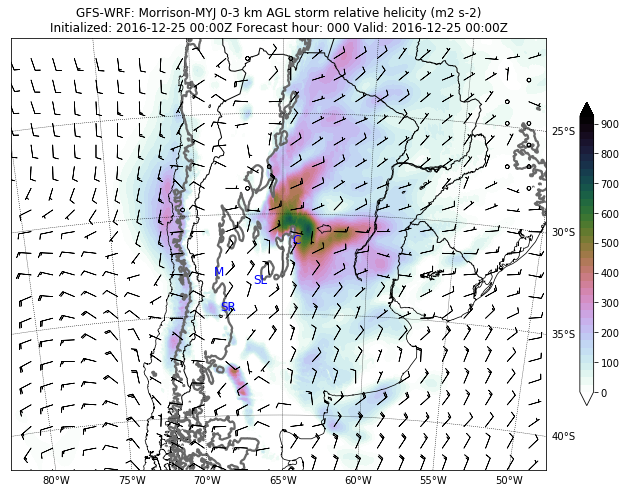

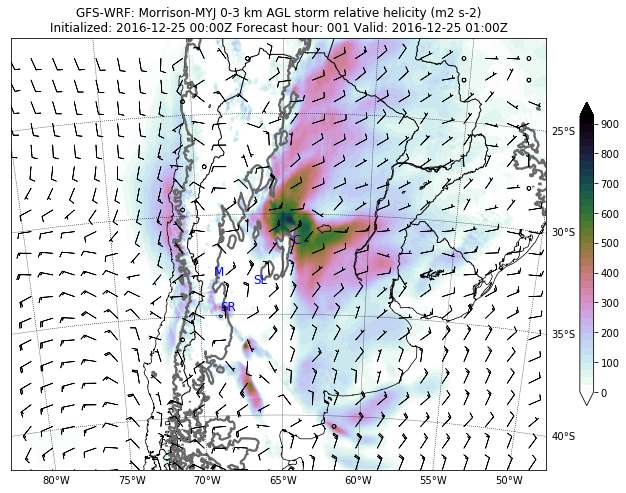

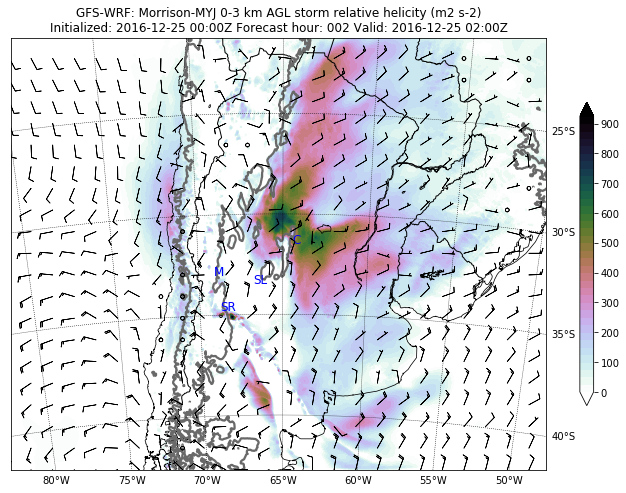

In [15]:
#=========================0-3 km SRH=========================
    
## Important: the following through tindex=i must be added to Nesbitt's code for each variable, such as pw.
## Indentation matters! take the bottom top dimension- 4d variable

outpath = 'DEC16_images/'+ensemble+'/SRH_MIN3' # change directory names to fit variable AND ENSEMBLE!
for i,f in enumerate(files):
    if i>2:                           # change 'i>2' depending on how many indices aka times you want iterated
        break
    tindex=i
    
    params={'outpath':outpath,
            'modname':modname,
            'modfld':'0-3km_Storm_Relative_Helicity',
            'cfield':'SRH_MIN3',
            'clevels':np.arange(0,950,25),
            'ccmap':"cubehelix_r",
            'llevels':None,
            'llevels2':[1000],
            'time_index':tindex,
            'times':times,
            'zoom':zoom,
            'skip':17}

    try:
        cffield = getvar(files, 'helicity', timeidx=params['time_index'],top=3000.0)
        cffield.values=cffield.values*-1.
        cffield.attrs['description']='0-3 km AGL storm relative helicity'
        cffield.attrs['units']='m2 s-2'
        lfield = None
        lfield2 = getvar(files, 'ter', timeidx=params['time_index'], units='m')
        uvmet = getvar(files, 'uvmet10', timeidx=params['time_index'], units='kt')
        ufld = uvmet.isel(u_v=0)
        vfld = uvmet.isel(u_v=1)

        make_plot(cffield,lfield,lfield2,ufld,vfld,params)
    except: print(params['cfield']," is not in the file, skipping")
        
## Important: add the following to create proper directory and save .png in it
    
    ## Make directory for variable as defined above
    os.system('mkdir -p '+outpath)

    # save figure in outpath. named based on variable and time. must change '/pw_' for other variables
   # plt.savefig(outpath+'/'+zoom+'_SRH_MIN3_'+times[i].strftime('%Y-%m-%d_%H:%M:%S')+'.png', bbox_inches="tight", dpi=200)

0
1
2


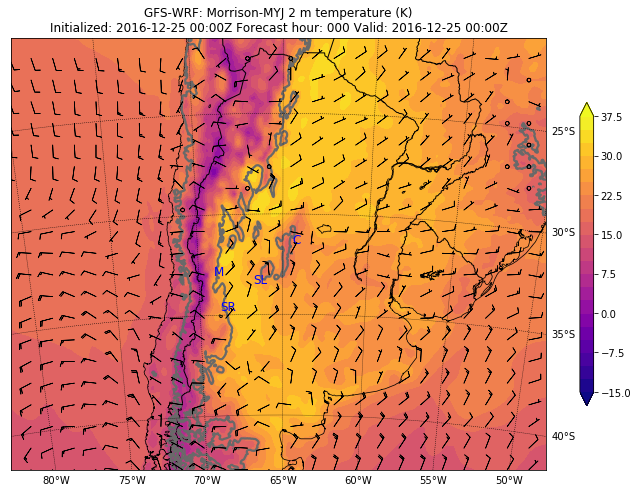

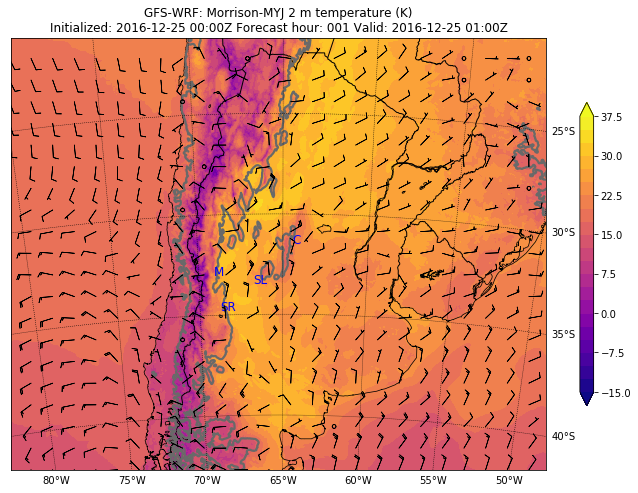

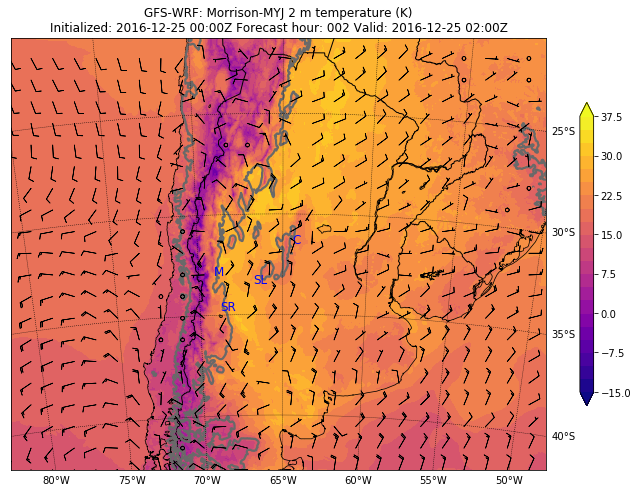

In [18]:
#=====================2 M TEMP=========================
    
## Important: the following through tindex=i must be added to Nesbitt's code for each variable, such as pw.
## Indentation matters!

outpath = 'DEC16_images/'+ensemble+'/T2' # change directory names to fit variable AND ENSEMBLE!
for i,f in enumerate(files):
    if i>2:                           # change 'i>2' depending on how many indices aka times you want iterated
        break
    tindex=i
    
    params={'outpath':outpath,
            'modname':modname,
            'modfld':'2m_Temperature',
            'cfield':'T2',
            'clevels':np.arange(-15,40,2.5),
            'ccmap':"plasma",
            'llevels':np.arange(970,1040,4),
            'llevels2':[1000],
            'time_index':tindex,
            'times':times,
            'zoom':zoom,
            'skip':17}

    cffield = getvar(files, params['cfield'], timeidx=params['time_index'],units='degC')
    cffield.attrs['description']='2 m temperature'
    cffield.attrs['temperature']='degC'
    cffield.values=cffield.values-273.15
    #lfield = getvar(files, 'slp', timeidx=params['time_index'], units='hPa')
    lfield = None
    lfield2 = getvar(files, 'ter', timeidx=params['time_index'], units='m')
    uvmet = getvar(files, 'uvmet10', timeidx=params['time_index'], units='kt')
    ufld = uvmet.isel(u_v=0)
    vfld = uvmet.isel(u_v=1)

    make_plot(cffield,lfield,lfield2,ufld,vfld,params)
    
## Important: add the following to create proper directory and save .png in it
    
    ## Make directory for variable as defined above
    os.system('mkdir -p '+outpath)

    # save figure in outpath. named based on variable and time. must change '/pw_' for other variables
    #plt.savefig(outpath+'/'+zoom+'_T2_'+times[i].strftime('%Y-%m-%d_%H:%M:%S')+'.png', bbox_inches="tight", dpi=200)

0


/glade/u/apps/ch/opt/pythonpkgs/2.7/matplotlib/2.0.2/gnu/6.3.0/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/glade/u/apps/ch/opt/pythonpkgs/2.7/matplotlib/2.0.2/gnu/6.3.0/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3572: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/glade/u/apps/ch/opt/pythonpkgs/2.7/matplotlib/2.0.2/gnu/6.3.0/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/glade/u/apps/ch/opt/pythonpkgs/2.7/matplotlib/2.0.2/gnu/6.3.0/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api

1
2


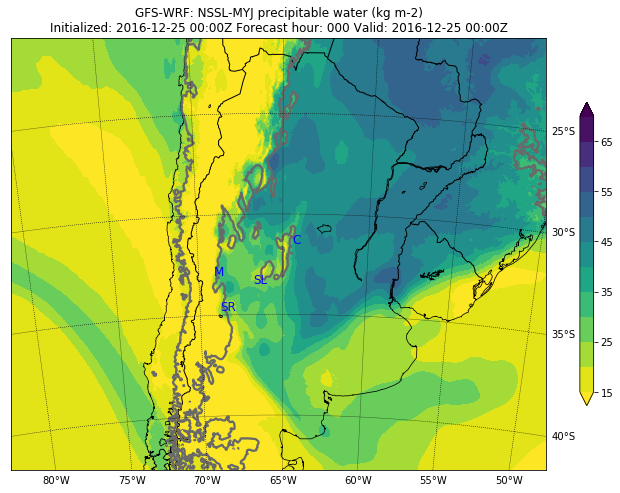

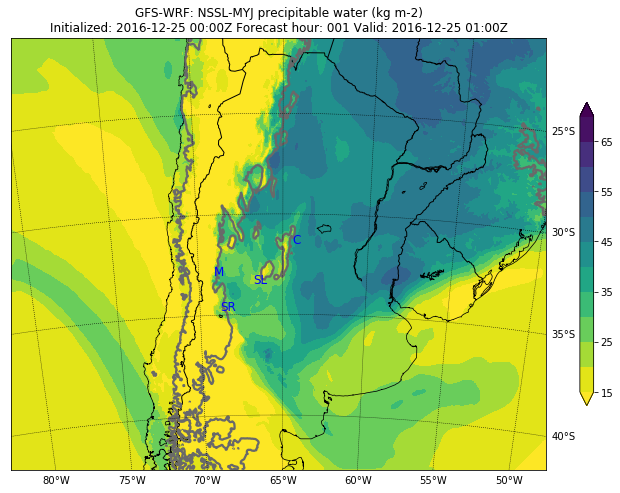

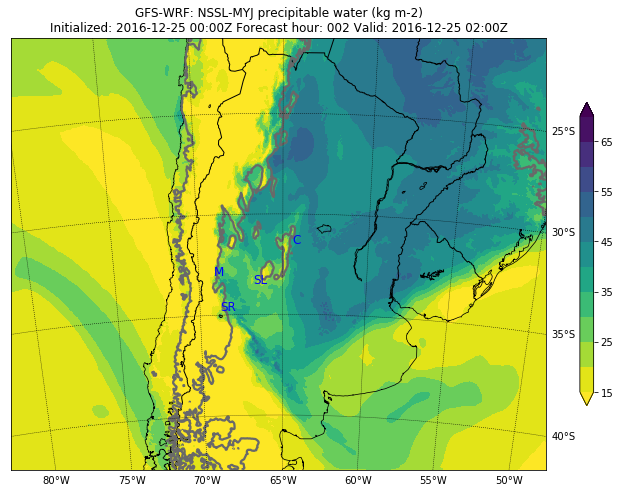

In [8]:
#=====================PRECIPITABLE WATER=========================

## Important: the following through tindex=i must be added to Nesbitt's code for each variable, such as pw.
## Indentation matters!

outpath = 'DEC16_images/'+ensemble+'/precip_water' # change directory names to fit variable AND ENSEMBLE!
for i,f in enumerate(files):
    if i>2:                           # change 'i>2' depending on how many indices aka times you want iterated
        break
    tindex=i
    
    params={'outpath':outpath,
            'modname':modname,
            'modfld':'Precipitable_Water',
            'cfield':'pw',
            'clevels':np.arange(15,75,5),
            'ccmap':"viridis_r",
            'llevels':None,
            'llevels2':[1000],
            'time_index':tindex,
            'times':times,
            'zoom':zoom,
            'skip':17}

    cffield = getvar(files, params['cfield'], timeidx=params['time_index'])
    lfield = None
    lfield2 = getvar(files, 'ter', timeidx=params['time_index'], units='m')
    ufld = None
    vfld = None

    make_plot(cffield,lfield,lfield2,ufld,vfld,params)
    

## Important: add the following to create proper directory and save .png in it
    
    ## Make directory for variable as defined above
    os.system('mkdir -p '+outpath)

    # save figure in outpath. named based on variable and time. must change '/pw_' for other variables
   # plt.savefig(outpath+'/'+zoom+'_pw_'+times[i].strftime('%Y-%m-%d_%H:%M:%S')+'.png', bbox_inches="tight", dpi=200)